# Files tree

```
./datasets
|
+---------MedicalDecathlon
|                   |
|                   +-----training
|                   |         |
|                   |         |
|                   |         +--- archives with the cts in nii.gz format
|                   |
|                   |
|                   |
|                   +-----validation
|                             |
|                             |
|                             +--- archives with the cts in nii.gz format
|
|
|
+---------MedicalDecathlonTensors
|                   |
|                   +-----training
|                   |         |
|                   |         |
|                   |         +--- files with the cts as tensors
|                   |
|                   |
|                   |
|                   +-----validation
|                             |
|                             |
|                             +---  files with the cts as tensors
|
|
|
|
+---------MedicalDecathlonJustLungs
|                   |
|                   +-----training
|                   |         |
|                   |         |
|                   |         +--- files with the cts as tensors
|                   |
|                   |
|                   |
|                   +-----validation
|                             |
|                             |
|                             +---  files with the cts as tensors
|
|
|
+---------MedicalDecathlonJustTumours
                    |
                    +-----training
                    |         |
                    |         |
                    |         +--- files with the cts as tensors
                    |
                    |
                    |
                    +-----validation
                              |
                              |
                              +---  files with the cts as tensors


```


### IMPORTS

In [22]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings


from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    Compose,
    OrientationD,
    OrientationD,
)

import torch
import numpy as np
import random
import sys
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt

In [23]:
import cv2

### HYPERPARAMS ###


In [24]:
crt_dir = os.getcwd()
datasets_path = f'{crt_dir}/datasets/MedicalDecathlon/'

DOWNLOAD_FLAG = False
BATCH_SIZE = 1

KEYS = ["image", "label"]

### PREPROCESSING TRANSFORMS

In [25]:
base_transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(keys=KEYS, axcodes='RAS'),
])

In [26]:
### TRAINING DATA ###
train_name = 'training' # From Monai: ['training', 'validation', 'test']
train_dataset = DecathlonDataset(root_dir = f'{datasets_path}{train_name}/',
                        task = "Task06_Lung", section = train_name,
                        transform = base_transform, download = DOWNLOAD_FLAG)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = num_workers)

Loading dataset: 100%|██████████| 51/51 [03:24<00:00,  4.02s/it]


### MAIN ###

In [27]:
# We make sure to eliminate uncertainty in the data loading, by setting all the random seeds

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [28]:
# Memoize stacks in between, where we find the lungs
# Based on the radiologist, some CTs start from kidney area up to the cervical backbone
patient_useful_slices = {
    0 : {'start': 60, 'stop': 557},
    1 : {'start': 20 , 'stop': 243},
    2 : {'start': 0, 'stop': 213},
    3 : {'start': 48, 'stop': 437},
    4 : {'start': 52, 'stop': 258},
    5 : {'start': 59, 'stop': 244},
    6 : {'start': 9, 'stop': 122},
    7 : {'start': 44, 'stop': 260},
    8 : {'start': 3, 'stop': 237},
    9 : {'start': 330 , 'stop': 623},
    10 : {'start': 56, 'stop': 280},
    11 : {'start': 26, 'stop': 292},
    12 : {'start': 0, 'stop': 108},
    13 : {'start': 10, 'stop': 227},
    14 : {'start': 25, 'stop': 231},
    15 : {'start': 35, 'stop': 280},
    16 : {'start': 37, 'stop': 262},
    17 : {'start': 29, 'stop': 266},
    18 : {'start': 48, 'stop': 261},
    19 : {'start': 65, 'stop': 275},
    20 : {'start': 145, 'stop': 520},
    21 : {'start': 0, 'stop': 397},
    22 : {'start': 9, 'stop': 225},
    23 : {'start': 6, 'stop': 227},
    24 : {'start': 15, 'stop': 239},
    25 : {'start': 40, 'stop': 149},
    26 : {'start': 30, 'stop': 231},
    27 : {'start': 49, 'stop': 295},
    28 : {'start': 33, 'stop': 217},
    29 : {'start': 50, 'stop': 311},
    30 : {'start': 0, 'stop': 213},
    31 : {'start': 22, 'stop': 248},
    32 : {'start': 88, 'stop': 493},
    33 : {'start': 116, 'stop': 439},
    34 : {'start': 40, 'stop': 300},
    35 : {'start': 0, 'stop': 227},
    36 : {'start': 0, 'stop': 198},
    37 : {'start': 0, 'stop': 120},
    38 : {'start': 0, 'stop': 203},
    39 : {'start': 44, 'stop': 228},
    40 : {'start': 0, 'stop': 229},
    41 : {'start': 35, 'stop': 250},
    42 : {'start': 48, 'stop': 243},
    43 : {'start': 5, 'stop': 230},
    44 : {'start': 88, 'stop': 314},
    45 : {'start': 7, 'stop': 220},
    46 : {'start': 11, 'stop': 232},
    47 : {'start': 21, 'stop': 229},
    48 : {'start': 4, 'stop': 255},
    49 : {'start': 2, 'stop': 122},
    50 : {'start': 14, 'stop': 119}
}

In [29]:
# Memoize stacks where the tumor is present
# Computed in MSD EDA notebook
patient_tumorous_slices = {
    0: {'start': 326, 'stop': 411},
    1: {'start': 171, 'stop': 227},
    2: {'start': 147, 'stop': 193},
    3: {'start': 303, 'stop': 335},
    4: {'start': 141, 'stop': 167},
    5: {'start': 131, 'stop': 188},
    6: {'start': 71, 'stop': 95},
    7: {'start': 164, 'stop': 192},
    8: {'start': 145, 'stop': 180},
    9: {'start': 513, 'stop': 549},
    10: {'start': 197, 'stop': 272},
    11: {'start': 223, 'stop': 258},
    12: {'start': 59, 'stop': 83},
    13: {'start': 59, 'stop': 99},
    14: {'start': 178, 'stop': 207},
    15: {'start': 141, 'stop': 172},
    16: {'start': 127, 'stop': 177},
    17: {'start': 192, 'stop': 221},
    18: {'start': 209, 'stop': 239},
    19: {'start': 152, 'stop': 194},
    20: {'start': 439, 'stop': 494},
    21: {'start': 291, 'stop': 341},
    22: {'start': 136, 'stop': 180},
    23: {'start': 137, 'stop': 169},
    24: {'start': 84, 'stop': 112},
    25: {'start': 82, 'stop': 109},
    26: {'start': 79, 'stop': 126},
    27: {'start': 208, 'stop': 293},
    28: {'start': 137, 'stop': 173},
    29: {'start': 120, 'stop': 149},
    30: {'start': 130, 'stop': 173},
    31: {'start': 97, 'stop': 123},
    32: {'start': 356, 'stop': 415},
    33: {'start': 203, 'stop': 287},
    34: {'start': 200, 'stop': 228},
    35: {'start': 148, 'stop': 184},
    36: {'start': 79, 'stop': 105},
    37: {'start': 66, 'stop': 100},
    38: {'start': 117, 'stop': 143},
    39: {'start': 111, 'stop': 181},
    40: {'start': 140, 'stop': 165},
    41: {'start': 80, 'stop': 109},
    42: {'start': 79, 'stop': 172},
    43: {'start': 153, 'stop': 204},
    44: {'start': 147, 'stop': 188},
    45: {'start': 113, 'stop': 142},
    46: {'start': 83, 'stop': 113},
    47: {'start': 140, 'stop': 234},
    48: {'start': 141, 'stop': 170},
    49: {'start': 99, 'stop': 120},
    50: {'start': 68, 'stop': 92}
}

In [30]:
# Memoize the bounding boxes for 2D slices to remove the bed and other noise signals
# More details in niibabel.ipynb
bbox_2d = (60, 450, 119, 425)


In [31]:
crt_patient = train_dataset[0]['image']

In [32]:
from copy import deepcopy

In [33]:

def min_max_normalize(img):
    no_stacks = img.shape[-1]

    for i in range(no_stacks):
        img[:, :, :, i] = (img[:, :, :, i] - img[:, :, :, i].min()) / (img[:, :, :, i].max() - img[:, :, :, i].min())

    return img

def clahe_normalize(img, clahe_filter):
    print('CLAHE normalization')
    no_stacks = img.shape[-1]

    for i in range(no_stacks):
        img[0, ..., i]  = torch.Tensor(clahe_filter.apply(img[0, ..., i].numpy().astype(np.uint8)))

    return img

def remove_bed(img, bbox):
    '''
    Remove the bed from the image
    '''

    min_img = img.min()
    new_img = torch.ones_like(img) * min_img

    new_img[:, bbox[0]:bbox[1], bbox[2]:bbox[3], :] = img[:, bbox[0]:bbox[1], bbox[2]:bbox[3], :] 

    return new_img


def save_dataset(dataset, dataset_name, split_name, take_slices_flag : bool = False, slices : {int : {str : int}} = None, normalize_flag : bool = False, normalization_method : str = 'min-max', remove_bed_flag : bool = False, lungs_bbox : (int, int, int, int) = None):
    '''
    Save the dataset to the disk per patient as two files: image and mask
    '''

    if not os.path.exists(f'{crt_dir}/datasets/{dataset_name}/'):
        os.makedirs(f'{crt_dir}/datasets/{dataset_name}/')
        os.makedirs(f'{crt_dir}/datasets/{dataset_name}/{split_name}/images/')
        os.makedirs(f'{crt_dir}/datasets/{dataset_name}/{split_name}/labels/')


    if not os.path.exists(f'{crt_dir}/datasets/{dataset_name}/{split_name}/'):
        os.makedirs(f'{crt_dir}/datasets/{dataset_name}/{split_name}/')
        os.makedirs(f'{crt_dir}/datasets/{dataset_name}/{split_name}/images/')
        os.makedirs(f'{crt_dir}/datasets/{dataset_name}/{split_name}/labels/')

    for i, data in enumerate(tqdm(dataset)):
        img, label = data['image'], data['label']
                
        new_img = img.cpu()
        new_label = label.cpu()

        # plt.imshow(img[0, ..., 5], cmap='gray')
        # plt.show()

        if take_slices_flag:
            print(slices[i]['start'], slices[i]['stop'])
            new_img = new_img[:, :, :, slices[i]['start'] : (slices[i]['stop']+1)]
            new_label = new_label[:, :, :, slices[i]['start'] : (slices[i]['stop']+1)]


        # print(f'Patient {i} has {img.shape[-1]} slices')

        # plt.imshow(new_img[0, ..., 5], cmap='gray')
        # plt.show()
        # sys.exit()


        if normalize_flag:
            if normalization_method == 'min-max':
                new_img = min_max_normalize(new_img)
            elif normalization_method == 'clahe':
                _clipLimit = 4.0
                clahe_filter = cv2.createCLAHE(clipLimit = _clipLimit)


                # plt.imshow(img[0, ..., 5], cmap='gray')
                # plt.show()


                new_img = clahe_normalize(new_img, clahe_filter)
            else:
                raise ValueError('Invalid normalization method')

        # plt.imshow(img[0, ..., 5], cmap='gray')
        # plt.show()
            
        if remove_bed_flag:
            new_img = remove_bed(new_img, lungs_bbox)

        # plt.imshow(img[0, ..., 5], cmap='gray')
        # plt.show()
        # plt.figure().clear()
        # plt.close('all')
        # sys.exit()


        print(f'Patient {i} has {img.shape[-1]} slices')

        filename = f'{crt_dir}/datasets/{dataset_name}/{split_name}/images/patient_{i}.pt'
        maskname = f'{crt_dir}/datasets/{dataset_name}/{split_name}/labels/patient_{i}.pt'

        torch.save(new_img, filename)
        torch.save(new_label, maskname)


    print(f'Saved {i} images and masks for {split_name} split')

  0%|          | 0/51 [00:00<?, ?it/s]

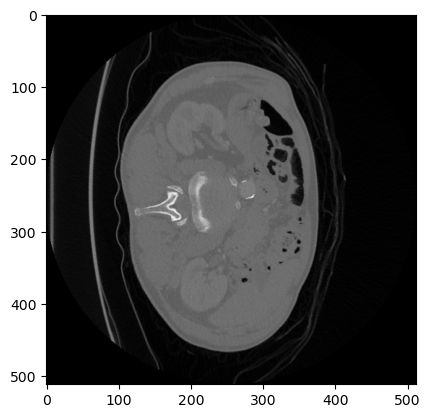

  0%|          | 0/51 [00:00<?, ?it/s]


Patient 0 has 589 slices


UnboundLocalError: local variable 'new_img' referenced before assignment

In [280]:
# save_dataset(train_dataset, 'MedicalDecathlonTensors', train_name)

  0%|          | 0/51 [00:00<?, ?it/s]

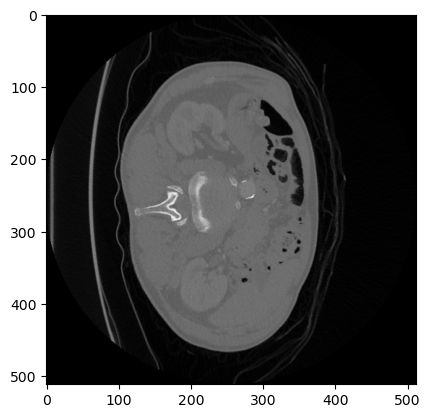

60 557
Patient 0 has 589 slices


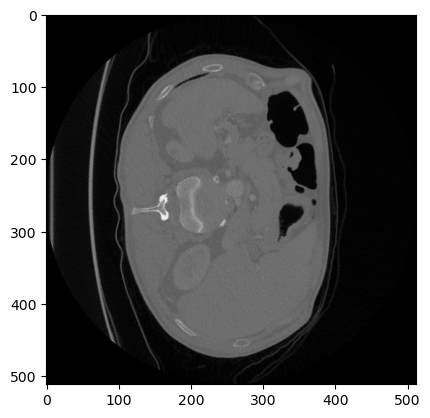

  0%|          | 0/51 [00:00<?, ?it/s]


SystemExit: 

In [281]:
save_dataset(train_dataset, 'MedicalDecathlonJustLungs', train_name, take_slices_flag = True, slices = patient_useful_slices)

In [310]:
# save_dataset(train_dataset, 'MedicalDecathlonJustTumors', train_name, take_slices_flag = True, slices = patient_tumorous_slices)

: 

In [34]:
save_dataset(train_dataset, 'MedicalDecathlonAugmentedTumors2', train_name, take_slices_flag = True, slices = patient_useful_slices, normalize_flag = True, normalization_method = 'min-max', remove_bed_flag = True, lungs_bbox = bbox_2d)

  0%|          | 0/51 [00:00<?, ?it/s]

60 557
Patient 0 has 589 slices


  2%|▏         | 1/51 [00:04<04:00,  4.81s/it]

20 243
Patient 1 has 267 slices


  4%|▍         | 2/51 [00:06<02:36,  3.20s/it]

0 213
Patient 2 has 227 slices


  6%|▌         | 3/51 [00:08<02:03,  2.57s/it]

48 437
Patient 3 has 450 slices


  8%|▊         | 4/51 [00:12<02:18,  2.95s/it]

52 258
Patient 4 has 277 slices


 10%|▉         | 5/51 [00:14<01:59,  2.59s/it]

59 244
Patient 5 has 260 slices


 12%|█▏        | 6/51 [00:15<01:44,  2.33s/it]

9 122
Patient 6 has 125 slices


 14%|█▎        | 7/51 [00:17<01:24,  1.91s/it]

44 260
Patient 7 has 273 slices


 16%|█▌        | 8/51 [00:19<01:23,  1.94s/it]

3 237
Patient 8 has 251 slices


 18%|█▊        | 9/51 [00:21<01:22,  1.96s/it]

330 623
Patient 9 has 636 slices


 20%|█▉        | 10/51 [00:24<01:40,  2.45s/it]

56 280
Patient 10 has 301 slices


 22%|██▏       | 11/51 [00:26<01:34,  2.36s/it]

26 292
Patient 11 has 304 slices


 24%|██▎       | 12/51 [00:29<01:32,  2.38s/it]

0 108
Patient 12 has 115 slices


 25%|██▌       | 13/51 [00:30<01:14,  1.95s/it]

10 227
Patient 13 has 241 slices


 27%|██▋       | 14/51 [00:32<01:12,  1.95s/it]

25 231
Patient 14 has 249 slices


 29%|██▉       | 15/51 [00:34<01:10,  1.95s/it]

35 280
Patient 15 has 289 slices


 31%|███▏      | 16/51 [00:36<01:11,  2.03s/it]

37 262
Patient 16 has 282 slices


 33%|███▎      | 17/51 [00:38<01:09,  2.04s/it]

29 266
Patient 17 has 291 slices


 35%|███▌      | 18/51 [00:40<01:08,  2.08s/it]

48 261
Patient 18 has 276 slices


 37%|███▋      | 19/51 [00:42<01:05,  2.03s/it]

65 275
Patient 19 has 296 slices


 39%|███▉      | 20/51 [00:44<01:03,  2.06s/it]

145 520
Patient 20 has 567 slices


 41%|████      | 21/51 [00:48<01:16,  2.57s/it]

0 397
Patient 21 has 423 slices


 43%|████▎     | 22/51 [00:53<01:34,  3.25s/it]

9 225
Patient 22 has 242 slices


 45%|████▌     | 23/51 [00:55<01:20,  2.86s/it]

6 227
Patient 23 has 243 slices


 47%|████▋     | 24/51 [00:56<01:06,  2.47s/it]

15 239
Patient 24 has 251 slices


 49%|████▉     | 25/51 [00:57<00:52,  2.02s/it]

40 149
Patient 25 has 155 slices


 51%|█████     | 26/51 [00:58<00:39,  1.59s/it]

30 231
Patient 26 has 241 slices


 53%|█████▎    | 27/51 [00:59<00:33,  1.40s/it]

49 295


 55%|█████▍    | 28/51 [01:00<00:29,  1.29s/it]

Patient 27 has 304 slices
33 217


 57%|█████▋    | 29/51 [01:01<00:25,  1.14s/it]

Patient 28 has 228 slices
50 311
Patient 29 has 322 slices


 59%|█████▉    | 30/51 [01:02<00:24,  1.15s/it]

0 213
Patient 30 has 226 slices


 61%|██████    | 31/51 [01:03<00:21,  1.07s/it]

22 248


 63%|██████▎   | 32/51 [01:04<00:21,  1.15s/it]

Patient 31 has 256 slices
88 493
Patient 32 has 531 slices


 65%|██████▍   | 33/51 [01:06<00:24,  1.35s/it]

116 439


 67%|██████▋   | 34/51 [01:07<00:24,  1.42s/it]

Patient 33 has 483 slices
40 300
Patient 34 has 314 slices


 69%|██████▊   | 35/51 [01:08<00:21,  1.33s/it]

0 227
Patient 35 has 241 slices


 71%|███████   | 36/51 [01:09<00:18,  1.22s/it]

0 198


 73%|███████▎  | 37/51 [01:10<00:15,  1.11s/it]

Patient 36 has 211 slices
0 120


 75%|███████▍  | 38/51 [01:11<00:13,  1.00s/it]

Patient 37 has 128 slices
0 203


 76%|███████▋  | 39/51 [01:12<00:11,  1.03it/s]

Patient 38 has 218 slices
44 228


 78%|███████▊  | 40/51 [01:13<00:10,  1.07it/s]

Patient 39 has 248 slices
0 229
Patient 40 has 241 slices


 80%|████████  | 41/51 [01:14<00:09,  1.07it/s]

35 250
Patient 41 has 271 slices


 82%|████████▏ | 42/51 [01:15<00:08,  1.07it/s]

48 243


 84%|████████▍ | 43/51 [01:15<00:07,  1.11it/s]

Patient 42 has 251 slices
5 230
Patient 43 has 241 slices


 86%|████████▋ | 44/51 [01:16<00:06,  1.07it/s]

88 314
Patient 44 has 329 slices


 88%|████████▊ | 45/51 [01:18<00:05,  1.01it/s]

7 220
Patient 45 has 228 slices


 90%|█████████ | 46/51 [01:18<00:04,  1.05it/s]

11 232


 92%|█████████▏| 47/51 [01:19<00:03,  1.06it/s]

Patient 46 has 242 slices
21 229
Patient 47 has 252 slices


 94%|█████████▍| 48/51 [01:20<00:02,  1.09it/s]

4 255
Patient 48 has 266 slices


 96%|█████████▌| 49/51 [01:21<00:01,  1.06it/s]

2 122
Patient 49 has 126 slices


 98%|█████████▊| 50/51 [01:22<00:00,  1.24it/s]

14 119
Patient 50 has 125 slices


100%|██████████| 51/51 [01:22<00:00,  1.62s/it]

Saved 50 images and masks for training split


In [254]:
# save_dataset(train_dataset, 'MedicalDecathlonClaheTumors', train_name, take_slices_flag = True, slices = patient_tumorous_slices, normalize_flag = True, normalization_method = 'clahe', remove_bed_flag = True, lungs_bbox = bbox_2d)

  0%|          | 0/51 [00:00<?, ?it/s]

Patient 0 has 86 slices
CLAHE normalization
Patient 0 has 86 slices


  2%|▏         | 1/51 [00:01<01:00,  1.22s/it]

Patient 1 has 57 slices
CLAHE normalization


  4%|▍         | 2/51 [00:01<00:44,  1.10it/s]

Patient 1 has 57 slices
Patient 2 has 47 slices
CLAHE normalization
Patient 2 has 47 slices


  6%|▌         | 3/51 [00:02<00:34,  1.38it/s]

Patient 3 has 33 slices
CLAHE normalization
Patient 3 has 33 slices


  8%|▊         | 4/51 [00:03<00:33,  1.42it/s]

Patient 4 has 27 slices
CLAHE normalization
Patient 4 has 27 slices


 10%|▉         | 5/51 [00:03<00:28,  1.62it/s]

Patient 5 has 58 slices
CLAHE normalization
Patient 5 has 58 slices


 12%|█▏        | 6/51 [00:04<00:27,  1.63it/s]

Patient 6 has 25 slices
CLAHE normalization
Patient 6 has 25 slices


 14%|█▎        | 7/51 [00:04<00:22,  1.99it/s]

Patient 7 has 29 slices
CLAHE normalization
Patient 7 has 29 slices


 16%|█▌        | 8/51 [00:04<00:21,  2.04it/s]

Patient 8 has 36 slices
CLAHE normalization
Patient 8 has 36 slices


 18%|█▊        | 9/51 [00:05<00:20,  2.06it/s]

Patient 9 has 37 slices
CLAHE normalization
Patient 9 has 37 slices


 20%|█▉        | 10/51 [00:06<00:25,  1.63it/s]

Patient 10 has 76 slices
CLAHE normalization
Patient 10 has 76 slices


 22%|██▏       | 11/51 [00:07<00:26,  1.50it/s]

Patient 11 has 36 slices
CLAHE normalization
Patient 11 has 36 slices


 24%|██▎       | 12/51 [00:07<00:25,  1.55it/s]

Patient 12 has 25 slices
CLAHE normalization
Patient 12 has 25 slices


 25%|██▌       | 13/51 [00:07<00:20,  1.88it/s]

Patient 13 has 41 slices
CLAHE normalization
Patient 13 has 41 slices


 27%|██▋       | 14/51 [00:08<00:19,  1.93it/s]

Patient 14 has 30 slices
CLAHE normalization
Patient 14 has 30 slices


 29%|██▉       | 15/51 [00:08<00:17,  2.02it/s]

Patient 15 has 32 slices
CLAHE normalization
Patient 15 has 32 slices


 31%|███▏      | 16/51 [00:09<00:17,  2.02it/s]

Patient 16 has 51 slices
CLAHE normalization
Patient 16 has 51 slices


 33%|███▎      | 17/51 [00:09<00:17,  1.90it/s]

Patient 17 has 30 slices
CLAHE normalization
Patient 17 has 30 slices


 35%|███▌      | 18/51 [00:10<00:17,  1.89it/s]

Patient 18 has 31 slices
CLAHE normalization
Patient 18 has 31 slices


 37%|███▋      | 19/51 [00:10<00:16,  1.95it/s]

Patient 19 has 43 slices
CLAHE normalization
Patient 19 has 43 slices


 39%|███▉      | 20/51 [00:11<00:16,  1.90it/s]

Patient 20 has 56 slices
CLAHE normalization
Patient 20 has 56 slices


 41%|████      | 21/51 [00:12<00:19,  1.55it/s]

Patient 21 has 51 slices
CLAHE normalization


 43%|████▎     | 22/51 [00:13<00:19,  1.48it/s]

Patient 21 has 51 slices
Patient 22 has 45 slices
CLAHE normalization
Patient 22 has 45 slices


 45%|████▌     | 23/51 [00:13<00:17,  1.61it/s]

Patient 23 has 33 slices
CLAHE normalization
Patient 23 has 33 slices


 47%|████▋     | 24/51 [00:14<00:15,  1.70it/s]

Patient 24 has 29 slices
CLAHE normalization
Patient 24 has 29 slices


 49%|████▉     | 25/51 [00:14<00:14,  1.84it/s]

Patient 25 has 28 slices
CLAHE normalization
Patient 25 has 28 slices


 51%|█████     | 26/51 [00:14<00:11,  2.09it/s]

Patient 26 has 48 slices
CLAHE normalization
Patient 26 has 48 slices


 53%|█████▎    | 27/51 [00:15<00:11,  2.01it/s]

Patient 27 has 86 slices
CLAHE normalization
Patient 27 has 86 slices


 55%|█████▍    | 28/51 [00:16<00:13,  1.71it/s]

Patient 28 has 37 slices
CLAHE normalization
Patient 28 has 37 slices


 57%|█████▋    | 29/51 [00:16<00:11,  1.84it/s]

Patient 29 has 30 slices
CLAHE normalization
Patient 29 has 30 slices


 59%|█████▉    | 30/51 [00:17<00:11,  1.83it/s]

Patient 30 has 44 slices
CLAHE normalization
Patient 30 has 44 slices


 61%|██████    | 31/51 [00:17<00:10,  1.90it/s]

Patient 31 has 27 slices
CLAHE normalization
Patient 31 has 27 slices


 63%|██████▎   | 32/51 [00:18<00:09,  1.97it/s]

Patient 32 has 60 slices
CLAHE normalization
Patient 32 has 60 slices


 65%|██████▍   | 33/51 [00:19<00:11,  1.59it/s]

Patient 33 has 85 slices
CLAHE normalization
Patient 33 has 85 slices


 67%|██████▋   | 34/51 [00:20<00:12,  1.34it/s]

Patient 34 has 29 slices
CLAHE normalization
Patient 34 has 29 slices


 69%|██████▊   | 35/51 [00:20<00:11,  1.45it/s]

Patient 35 has 37 slices
CLAHE normalization
Patient 35 has 37 slices


 71%|███████   | 36/51 [00:21<00:09,  1.56it/s]

Patient 36 has 27 slices
CLAHE normalization
Patient 36 has 27 slices


 73%|███████▎  | 37/51 [00:21<00:07,  1.77it/s]

Patient 37 has 35 slices
CLAHE normalization
Patient 37 has 35 slices


 75%|███████▍  | 38/51 [00:21<00:06,  1.99it/s]

Patient 38 has 27 slices
CLAHE normalization
Patient 38 has 27 slices


 76%|███████▋  | 39/51 [00:22<00:05,  2.13it/s]

Patient 39 has 71 slices
CLAHE normalization
Patient 39 has 71 slices


 78%|███████▊  | 40/51 [00:23<00:05,  1.91it/s]

Patient 40 has 26 slices
CLAHE normalization
Patient 40 has 26 slices


 80%|████████  | 41/51 [00:23<00:04,  2.04it/s]

Patient 41 has 30 slices
CLAHE normalization
Patient 41 has 30 slices


 82%|████████▏ | 42/51 [00:23<00:04,  1.99it/s]

Patient 42 has 94 slices
CLAHE normalization
Patient 42 has 94 slices


 84%|████████▍ | 43/51 [00:24<00:04,  1.70it/s]

Patient 43 has 52 slices
CLAHE normalization
Patient 43 has 52 slices


 86%|████████▋ | 44/51 [00:25<00:04,  1.73it/s]

Patient 44 has 42 slices
CLAHE normalization
Patient 44 has 42 slices


 88%|████████▊ | 45/51 [00:25<00:03,  1.71it/s]

Patient 45 has 30 slices
CLAHE normalization
Patient 45 has 30 slices


 90%|█████████ | 46/51 [00:26<00:02,  1.88it/s]

Patient 46 has 31 slices
CLAHE normalization
Patient 46 has 31 slices


 92%|█████████▏| 47/51 [00:26<00:02,  2.00it/s]

Patient 47 has 95 slices
CLAHE normalization
Patient 47 has 95 slices


 94%|█████████▍| 48/51 [00:27<00:01,  1.68it/s]

Patient 48 has 30 slices
CLAHE normalization
Patient 48 has 30 slices


 96%|█████████▌| 49/51 [00:28<00:01,  1.79it/s]

Patient 49 has 22 slices
CLAHE normalization
Patient 49 has 22 slices


 98%|█████████▊| 50/51 [00:28<00:00,  2.13it/s]

Patient 50 has 25 slices
CLAHE normalization
Patient 50 has 25 slices


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Saved 51 images and masks for training split


In [35]:
### VALIDATION DATA ###
val_name = 'validation' # From Monai: ['training', 'validation', 'test']
val_dataset = DecathlonDataset(root_dir = f'{datasets_path}{val_name}/',
                        task = "Task06_Lung", section = val_name,
                        transform = base_transform, download = DOWNLOAD_FLAG)

val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = num_workers)


Loading dataset: 100%|██████████| 12/12 [00:54<00:00,  4.54s/it]


In [12]:
# save_dataset(val_dataset, 'MedicalDecathlonJustTumors', val_name)

  0%|          | 0/12 [00:00<?, ?it/s]

Patient 0 has 369 slices


 25%|██▌       | 3/12 [00:02<00:05,  1.53it/s]

Patient 1 has 255 slices
Patient 2 has 288 slices


 42%|████▏     | 5/12 [00:03<00:03,  1.82it/s]

Patient 3 has 376 slices
Patient 4 has 112 slices


 58%|█████▊    | 7/12 [00:04<00:02,  1.82it/s]

Patient 5 has 245 slices
Patient 6 has 252 slices


 75%|███████▌  | 9/12 [00:04<00:01,  2.19it/s]

Patient 7 has 231 slices
Patient 8 has 129 slices


 92%|█████████▏| 11/12 [00:06<00:00,  1.51it/s]

Patient 9 has 240 slices
Patient 10 has 493 slices


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Patient 11 has 264 slices
Saved 12 images and masks for validation split


In [36]:
save_dataset(val_dataset, 'MedicalDecathlonAugmentedTumors2', val_name, normalize_flag = True, normalization_method = 'min-max', remove_bed_flag = True, lungs_bbox = bbox_2d)

  0%|          | 0/12 [00:00<?, ?it/s]

Patient 0 has 369 slices


  8%|▊         | 1/12 [00:01<00:16,  1.54s/it]

Patient 1 has 255 slices


 17%|█▋        | 2/12 [00:02<00:12,  1.22s/it]

Patient 2 has 288 slices


 25%|██▌       | 3/12 [00:03<00:11,  1.22s/it]

Patient 3 has 376 slices


 42%|████▏     | 5/12 [00:05<00:07,  1.03s/it]

Patient 4 has 112 slices
Patient 5 has 245 slices


 50%|█████     | 6/12 [00:06<00:06,  1.01s/it]

Patient 6 has 252 slices


 67%|██████▋   | 8/12 [00:09<00:04,  1.11s/it]

Patient 7 has 231 slices


 75%|███████▌  | 9/12 [00:09<00:02,  1.04it/s]

Patient 8 has 129 slices


 83%|████████▎ | 10/12 [00:11<00:02,  1.15s/it]

Patient 9 has 240 slices
Patient 10 has 493 slices


 92%|█████████▏| 11/12 [00:24<00:04,  4.75s/it]

Patient 11 has 264 slices


100%|██████████| 12/12 [00:31<00:00,  2.58s/it]

Saved 11 images and masks for validation split


In [260]:
save_dataset(val_dataset, 'MedicalDecathlonClaheTumors', val_name, normalize_flag = True, normalization_method = 'clahe', remove_bed_flag = True, lungs_bbox = bbox_2d)

  0%|          | 0/12 [00:00<?, ?it/s]

Patient 0 has 369 slices
CLAHE normalization
Patient 0 has 369 slices


  8%|▊         | 1/12 [00:04<00:45,  4.14s/it]

Patient 1 has 255 slices
CLAHE normalization
Patient 1 has 255 slices


 17%|█▋        | 2/12 [00:07<00:34,  3.40s/it]

Patient 2 has 288 slices
CLAHE normalization
Patient 2 has 288 slices


 25%|██▌       | 3/12 [00:10<00:29,  3.26s/it]

Patient 3 has 376 slices
CLAHE normalization
Patient 3 has 376 slices


 33%|███▎      | 4/12 [00:14<00:28,  3.58s/it]

Patient 4 has 112 slices
CLAHE normalization
Patient 4 has 112 slices


 42%|████▏     | 5/12 [00:15<00:19,  2.73s/it]

Patient 5 has 245 slices
CLAHE normalization
Patient 5 has 245 slices


 50%|█████     | 6/12 [00:18<00:16,  2.70s/it]

Patient 6 has 252 slices
CLAHE normalization
Patient 6 has 252 slices


 58%|█████▊    | 7/12 [00:20<00:13,  2.69s/it]

Patient 7 has 231 slices
CLAHE normalization
Patient 7 has 231 slices


 67%|██████▋   | 8/12 [00:23<00:10,  2.65s/it]

Patient 8 has 129 slices
CLAHE normalization
Patient 8 has 129 slices


 75%|███████▌  | 9/12 [00:24<00:06,  2.28s/it]

Patient 9 has 240 slices
CLAHE normalization
Patient 9 has 240 slices


 83%|████████▎ | 10/12 [00:27<00:04,  2.49s/it]

Patient 10 has 493 slices
CLAHE normalization
Patient 10 has 493 slices


 92%|█████████▏| 11/12 [00:33<00:03,  3.43s/it]

Patient 11 has 264 slices
CLAHE normalization
Patient 11 has 264 slices


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]

Saved 12 images and masks for validation split
